# Описание

Это учебное соревнование в рамках курса “Глубокое обучение в науках о данных”. В нем вам предстоит построить модель, классифицирующую изображения с одеждой, построенную на датасете Fashion-MNIST. Подробнее о датасете можно узнать во вкладке Data. Задача будет считаться решенной, если в Public Leaderboard вы наберете score, который будет равен или больше 0.80. В качестве метрики используется accuracy. В день вы можете отправлять не более 20 решений (это ограничения платформы). Помните, что решения принимаются только в том формате, который представлен в файле sample_submission.csv.

# Описание Dataset

**Fashion-MNIST** – аналог знаменитого датасета MNIST, который состоит не из рукописных символов, а из предметов одежды. Он был создан, чтобы актуализировать учебные задачи в компьютерном зрении и приблизить их к реальности.

Решение более сложной постановки этой задачи может использоваться, например, в маркетплейсах. Покупателю могут рекомендоваться товары по изображениям в соответствии с введённым описанием. Продавцу при загрузке изображений в карточку товара могут автоматически рекомендоваться теги и описание предмета одежды.

Каждое изображение представляет собой набор их 784 пикселей (28x28). Каждый пиксель принимает значение от 0 до 255, обозначая его цвет в черно-белой шкале. Обучающая выборка содержит 786 столбцов, где первый (label) – принадлежность изображения к классу, а последний – его уникальный номер (id). Остальные столбцы – пиксели изображения.
Проведите первичный анализ данных, чтобы определить наличие NaN значений.
Тестовая выборка (на основе которой должно быть получено исследование) содержит все те же столбцы, кроме label.

Расшифровка классов (label), к которым принадлежат изображения:

* 0 T-shirt/top – футболка
* 1 Trouser – брюки
* 2 Pullover – свитер
* 3 Dress – платье
* 4 Coat – пальто
* 5 Sandal – сандалия
* 6 Shirt – рубашка
* 7 Sneaker – кроссовок
* 8 Bag – сумка
* 9 Ankle boot – сапог

Структура данных:

* fmnist_train.csv – обучающая выборка
* fmnist_test.csv – тестовая выборка (на которой должно быть получено предсказание)
* sample_submission.csv – пример решения

# Иморты

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers

import sys

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', keras.__version__)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Python       : 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]
Numpy        : 1.23.5
Tensorflow   : 2.12.0
Keras        : 2.12.0


In [2]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# GPU & drivers
!nvidia-smi

Mon Jun 12 15:59:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |    372MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

# Данные

In [4]:
# Чтение данных
train = pd.read_csv('/kaggle/input/mds-mipt-dl-test-final/fmnist_train.csv')
test = pd.read_csv('/kaggle/input/mds-mipt-dl-test-final/fmnist_test.csv')
submission = pd.read_csv('/kaggle/input/mds-mipt-dl-test-final/sample_submission.csv')

labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
train.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,6,0,0,0,0,0,0,0,5,0,...,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0,2


In [6]:
test.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,0,0,0,0,0,0,0,9,8,0,...,87,56,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,14,53,99,17,...,0,0,0,63,53,31,0,0,0,2
3,0,0,0,0,0,0,0,0,0,161,...,126,140,0,133,224,222,56,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [7]:
submission.head(3)

,Id,label
0,0,0
1,1,0
2,2,0


In [8]:
# Размерность
print('Train:', train.shape)
print('Test:', test.shape)
print('Submission:', submission.shape)

Train: (17040, 786)
Test: (10000, 785)
Submission: (10000, 2)


In [9]:
# Количество категорий
train['label'].nunique()

10

In [10]:
# Количество пустых значений
train_nan = train.isna().values.sum()
test_nan = test.isna().values.sum()
print(f'Train NaN Count: {train_nan} Test NaN Count: {test_nan}')

Train NaN Count: 424 Test NaN Count: 0


In [11]:
# Большой вывод, поэтому стоит комментарий
#train.info(verbose=True, show_counts=True)

# Переменные

In [12]:
# Настройка переменных
RANDOM_SEED = 13
VAL_SPLIT = 0.2

EPOCHS = 60
BATCH_SIZE = 128
LR = 1e-3
EARLY_STOPPING = 10

FEATURES = list(train.loc[:, 'pixel1':'pixel784'])
TARGET = 'label'

CLASS_NUM = train[TARGET].nunique()
IMG_SIZE = 28
IMG_CHANNELS = 1
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# Предобработка

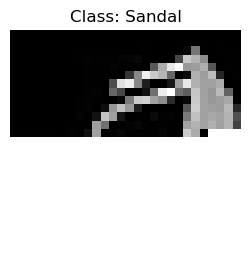

In [13]:
# Посмотрим на картинку без части данных
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot()
ax.grid('off')
ax.axis('off')
ax.imshow(train.loc[train['pixel490'].isna(), FEATURES
                    ].values.reshape(INPUT_SHAPE), cmap='gray')
ax.set_title('Class: ' + 
             labels[train.loc[train['pixel490'].isna(), TARGET].values[0]])
plt.show()

In [14]:
# Удаляю запись с пропусками, т.к. непонятно, что изображено
train = train.dropna()

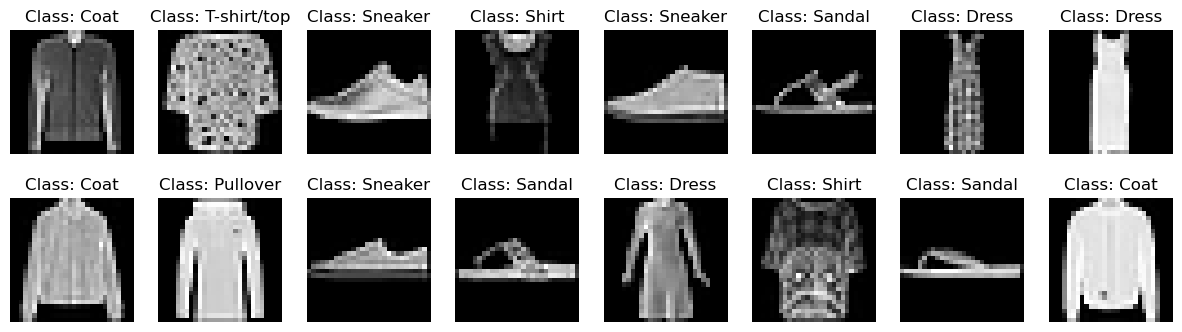

In [15]:
# Посмотрим на примеры картинок
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(train.loc[random_index, FEATURES
                            ].values.reshape(INPUT_SHAPE), cmap='gray')
        ax.set_title('Class: ' + labels[train.loc[random_index, TARGET]])
plt.show()

In [16]:
# Смотрим на равномерность распределения целевой переменной 
train[TARGET].value_counts()

0    1770
7    1761
3    1725
6    1704
1    1700
9    1694
5    1694
2    1677
8    1675
4    1639
Name: label, dtype: int64

In [17]:
# Разбиение выборки на тренировочную и валидационную
train_x_, val_x_, train_y, val_y = train_test_split(
    train.loc[:, FEATURES], train.loc[:, TARGET], 
    random_state=RANDOM_SEED, test_size=VAL_SPLIT, stratify=train[TARGET])

# Конвертируем метки в np.array
train_y = tf.keras.utils.to_categorical(train_y, CLASS_NUM)
val_y = tf.keras.utils.to_categorical(val_y, CLASS_NUM)

In [18]:
# Изменение размерности
train_x = train_x_.values.reshape(-1, *INPUT_SHAPE).astype(float)
print(train_x_.shape, train_x.shape)

val_x = val_x_.values.reshape(-1, *INPUT_SHAPE).astype(float)
print(val_x_.shape, val_x.shape)

test_x = test.drop(columns=['Id']).values.reshape(-1, *INPUT_SHAPE).astype(float)
print(test.shape, test_x.shape)

(13631, 784) (13631, 28, 28, 1)
(3408, 784) (3408, 28, 28, 1)
(10000, 785) (10000, 28, 28, 1)


In [19]:
# Центрируем и нормируем, так сети будет проще учиться
#train_.loc[:, FEATURES] = train_.loc[:, FEATURES].astype(np.float64) / 255 - 0.5
#val_.loc[:, FEATURES] = val_.loc[:, FEATURES].astype(np.float64) / 255 - 0.5

# Аугментация данных

In [20]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                     rotation_range=5,
                                     shear_range=0.2,
                                     zoom_range=[0.75, 1.25],
                                     brightness_range=[0.5, 1.5],
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=5,
                                   shear_range=0.2,
                                   zoom_range=[0.75, 1.25],
                                   brightness_range=[0.5, 1.5],
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
# "Заворачиваем" наши данные в generator
train_generator = train_datagen.flow(
    x=train_x,
    y=train_y,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED)

val_generator = val_datagen.flow(
    x=val_x,
    y=val_y,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=RANDOM_SEED)

test_generator = test_datagen.flow(
    x=test_x,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=RANDOM_SEED)

Пример картинок из train_generator


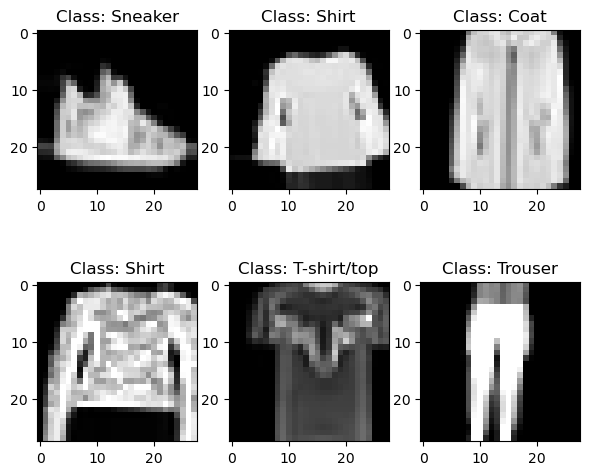

In [22]:
x, y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(7, 6))

for i in range(0,6):
    image = x[i]
    plt.subplot(2, 3, i+1)
    plt.imshow(image, cmap='gray')
    plt.title('Class: ' + labels[y.argmax(axis=1)[i]])
plt.show()

Пример картинок из val_generator


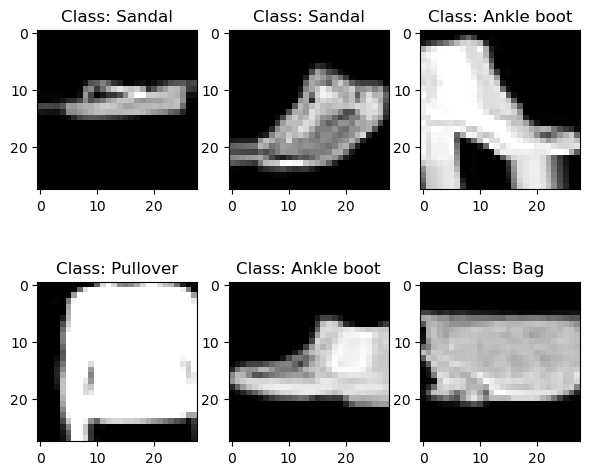

In [23]:
x, y = val_generator.next()
print('Пример картинок из val_generator')
plt.figure(figsize=(7, 6))

for i in range(0,6):
    image = x[i]
    plt.subplot(2, 3, i+1)
    plt.imshow(image, cmap='gray')
    plt.title('Class: ' + labels[y.argmax(axis=1)[i]])
plt.show()

# Первое решение

In [24]:
def make_default_model():
    
    model = M.Sequential()

    model.add(L.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=INPUT_SHAPE))
    model.add(L.BatchNormalization())
    model.add(L.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(L.BatchNormalization())
    model.add(L.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(L.BatchNormalization())
    model.add(L.MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(L.Dropout(0.25))
    model.add(L.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(L.BatchNormalization())
    model.add(L.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(L.BatchNormalization())
    model.add(L.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(L.BatchNormalization())
    model.add(L.MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(L.Dropout(0.25))
    model.add(L.Flatten())
    model.add(L.Dense(units=512, activation='elu'))
    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.5))
    model.add(L.Dense(units=CLASS_NUM, activation='softmax'))
    
    return model

In [25]:
def train_model(make_model_func=make_default_model, 
                optimizers_=optimizers.Adam(learning_rate=LR), 
                name_mod='best_model'):
    
    K.clear_session()
    model = make_model_func()   
    model.summary()
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers_,
        metrics='accuracy')

    checkpoint = ModelCheckpoint(f'{name_mod}.hdf5',
                                 monitor=['val_accuracy'],
                                 verbose=1, mode='max')
    
    earlystop = EarlyStopping(monitor='val_accuracy',
                              patience=EARLY_STOPPING,
                              restore_best_weights=True)
    
    callbacks_list = [checkpoint, earlystop]

    history = model.fit(
        train_generator,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_generator,
        shuffle=False,
        callbacks = callbacks_list
        )
    
    def plot_history(history):
        plt.figure(figsize=(10,5))
        plt.style.use('dark_background')
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(len(acc))

        plt.plot(epochs, acc, 'b', label='Training acc')
        plt.plot(epochs, val_acc, 'g', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()

        plt.figure(figsize=(10,5))
        plt.plot(epochs, loss, 'b', label='Training loss')
        plt.plot(epochs, val_loss, 'g', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()

        plt.show()
        return

    plot_history(history)

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_2 (Batc  (None, 28, 28, 64)       2

2023-06-12 15:59:34.433484: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


107/107 [==============================] - ETA: 0s - loss: 1.0479 - accuracy: 0.6636
Epoch 1: saving model to my_model_1.hdf5
107/107 [==============================] - 27s 119ms/step - loss: 1.0479 - accuracy: 0.6636 - val_loss: 8.6255 - val_accuracy: 0.1033
Epoch 2/60
106/107 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.7537
Epoch 2: saving model to my_model_1.hdf5
107/107 [==============================] - 12s 109ms/step - loss: 0.6842 - accuracy: 0.7536 - val_loss: 4.8683 - val_accuracy: 0.1303
Epoch 3/60
106/107 [============================>.] - ETA: 0s - loss: 0.6019 - accuracy: 0.7780
Epoch 3: saving model to my_model_1.hdf5
107/107 [==============================] - 12s 113ms/step - loss: 0.6009 - accuracy: 0.7783 - val_loss: 1.9049 - val_accuracy: 0.4046
Epoch 4/60
106/107 [============================>.] - ETA: 0s - loss: 0.5492 - accuracy: 0.7950
Epoch 4: saving model to my_model_1.hdf5
107/107 [==============================] - 12s 111ms/step - l

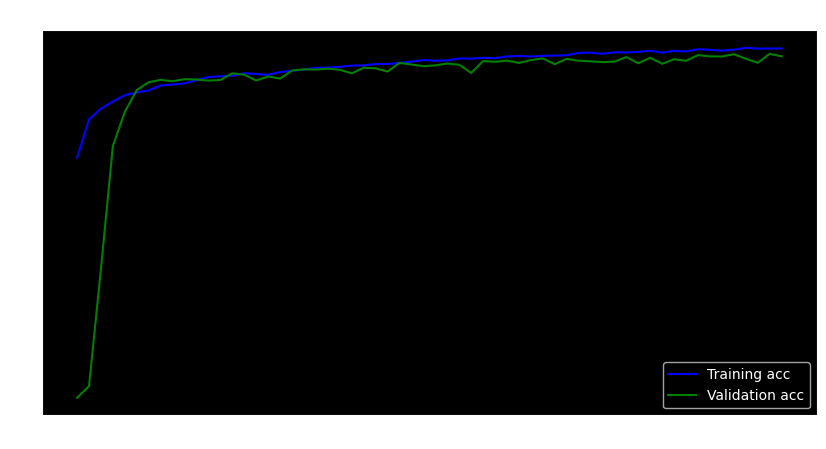

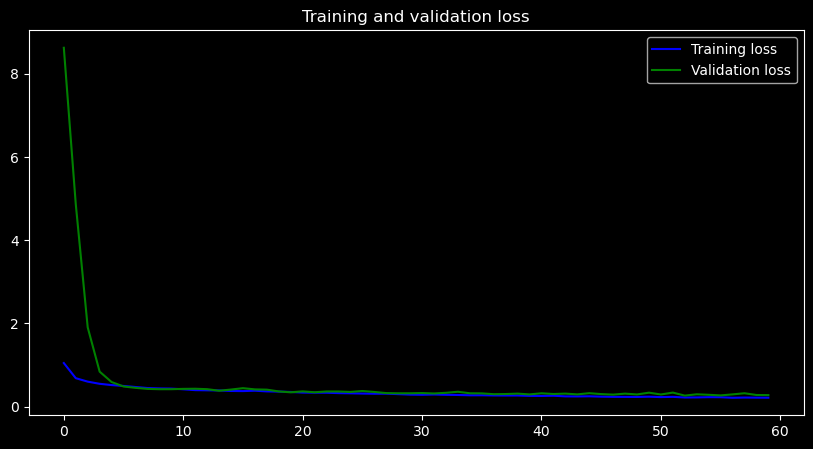

In [26]:
my_model_1 = train_model(name_mod='my_model_1', optimizers_=optimizers.Adamax(learning_rate=0.002))

# Вывод

In [27]:
predictions_1 = my_model_1.predict(test_generator)

submission_1 = pd.DataFrame({'Id': list(i for i in range(len(test_x))),
                             'Category': np.argmax(predictions_1, axis=1)})
#submission_1['Category'] = np.argmax(predictions_1, axis=1)

79/79 [==============================] - 1s 11ms/step


In [28]:
scores_1 = my_model_1.evaluate(val_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores_1[1]*100))

27/27 [==============================] - 2s 79ms/step - loss: 0.2825 - accuracy: 0.8976
Accuracy: 89.76%


Пример картинок из test_generator


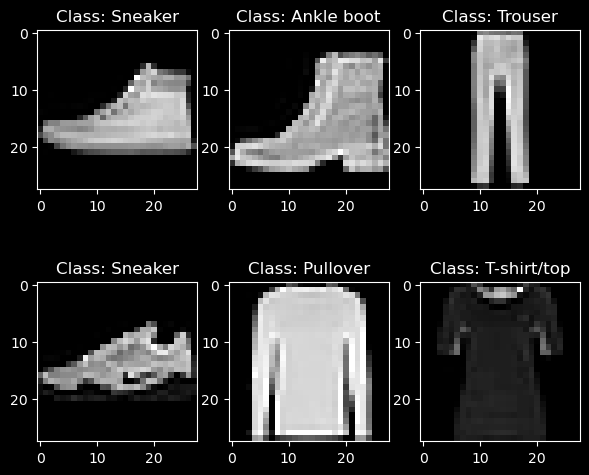

In [29]:
print('Пример картинок из test_generator')
plt.figure(figsize=(7, 6))

for i in range(0,6):
    random_index = np.random.randint(0, len(test_x))
    image = test_x[random_index]
    plt.subplot(2, 3, i+1)
    plt.imshow(image, cmap='gray')
    plt.title('Class: ' + labels[submission_1.loc[random_index, 'Category']])
plt.show()

In [30]:
submission_1.to_csv(
    f'/kaggle/working/submission{scores_1[1]}.csv',
    index=False, decimal='.')

In [31]:
pd.read_csv(f'/kaggle/working/submission{scores_1[1]}.csv')

,Id,Category
0,0,0
1,1,1
2,2,2
3,3,2
4,4,3
...,...,...
9995,9995,0
9996,9996,6
9997,9997,8
9998,9998,8
